## Implementierung gleitender Mittelwert

    Time  Observations  MovingAvg  Forecast_t+1
0    0.0      5.496714   5.496714           NaN
1    1.0      4.861736   5.179225      5.496714
2    2.0      5.647689   5.254712      5.179225
3    3.0      6.523030   6.085359      5.254712
4    4.0      4.765847   5.644438      6.085359
5    5.0      4.765863   4.765855      5.644438
6    6.0      6.579213   5.672538      4.765855
7    7.0      5.767435   6.173324      5.672538
8    8.0      4.530526   5.148980      6.173324
9    9.0      5.542560   5.036543      5.148980
10  10.0      4.536582   5.039571      5.036543
11  11.0      4.534270   4.535426      5.039571
12  12.0      5.241962   4.888116      4.535426
13  13.0      3.086720   4.164341      4.888116
14  14.0      3.275082   3.180901      4.164341
15  15.0      4.437712   3.856397      3.180901
16  16.0      3.987169   4.212441      3.856397
17  17.0      5.314247   4.650708      4.212441
18  18.0      4.091976   4.703112      4.650708
19  19.0      3.587696   3.839836      4

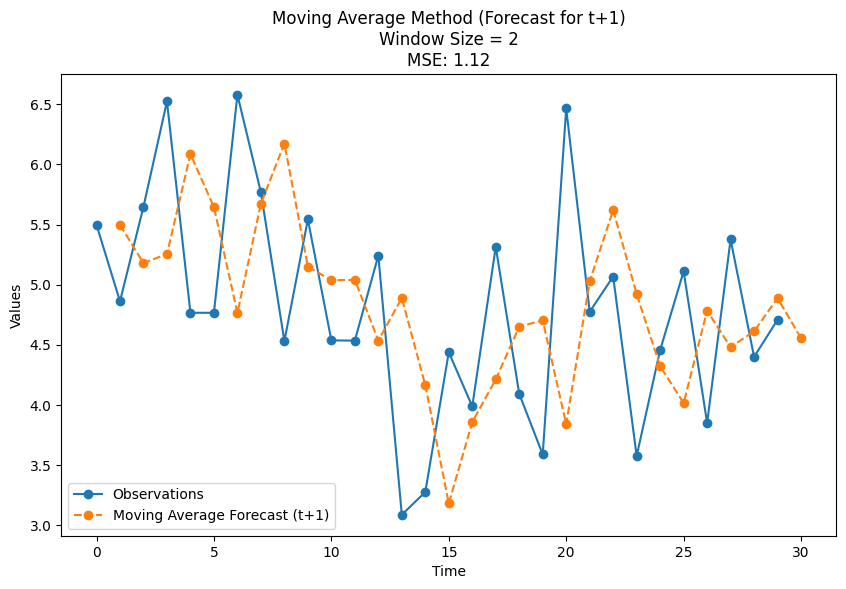

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Set seed of random number generator for reproducibility
np.random.seed(42)

# Generate exemplary data without seasonal component (stationary)
mean_value = 5
std_dev = 1
num_points = 30

data = {'Time': range(0, num_points),
        'Observations': np.random.normal(loc=mean_value, scale=std_dev, size=num_points)}

# Write the generated data to a pandas data frame
df = pd.DataFrame(data)

# Set the window size for the moving average, adjust if needed (bigger window -> more smoothing)
window_size = 2

# Add new column 'MovingAvg' to df and calculate the moving average (forecast for t+1)
df['MovingAvg'] = df['Observations'].rolling(window=window_size, min_periods=1, center=False).mean()


# The following steps are needed to adjust the df to create correct plots later
# It's recommended to plot time series data against time data when provided as the recorded steps might be unequal

#print(df) # Uncomment this line to show df before appending new column and row at end
df['Forecast_t+1'] = df['MovingAvg'] # Add new column to df to write forecast values t+1 into
time_step = df['Time'].iloc[-1] - df['Time'].iloc[-2] # Calculate time step in order to add to df['Time'] in new row
df.loc[len(df)] = [df['Time'].iloc[-1] + time_step , None, None, None] # Append row to df to shift df['MovingAvg'] by 1

# you can also use pd.concat as shown below:
#df = pd.concat([df, pd.DataFrame({'Time': df['Time'].iloc[-1] + time_step,
#                                  'Observations': [np.nan],
#                                  'MovingAvg': [np.nan],
#                                  'Forecast_t+1': [np.nan]})], ignore_index=True)

df['Forecast_t+1'] = df['MovingAvg'].shift(1) # shift df['MovingAvg'] by 1

print(df) # Adjusted df after adding column, row with next time step in 'Time' and shifted MovingAvg (Forecast_t+1)

# Calculate MSE for t+1. To do so the recorded observation values and forecasted values must be aligned
mse = mean_squared_error(df['Observations'][1:-1], df['Forecast_t+1'][1:-1])

#print(df['Observations']) # Uncomment this line to show unaligned df
#print(df['Observations'][1:-1]) # Uncomment this line to show aligned df
#print (df['Forecast_t+1']) # Uncomment this line to show unaligned df
#print (df['Forecast_t+1'][1:-1]) # Uncomment this line to show aligned df

# Plot of observations and moving average as forecast for t+1
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Observations'], label='Observations', marker='o')
plt.plot(df['Time'], df['Forecast_t+1'], label='Moving Average Forecast (t+1)', linestyle='dashed', marker='o')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Moving Average Method (Forecast for t+1)\nWindow Size = {}\nMSE: {:.2f}'.format(window_size, mse))
plt.show()


## Implementierung exponentielle Glättung 1. Ordnung

    Time  Observations  Forecast_t+1
0      0     10.496714     10.496714
1      1      9.861736     10.496714
2      2     10.647689     10.433216
3      3     11.523030     10.454664
4      4      9.765847     10.561500
5      5      9.765863     10.481935
6      6     11.579213     10.410328
7      7     10.767435     10.527216
8      8      9.530526     10.551238
9      9     10.542560     10.449167
10    10      9.536582     10.458506
11    11      9.534270     10.366314
12    12     10.241962     10.283109
13    13      8.086720     10.278995
14    14      8.275082     10.059767
15    15      9.437712      9.881299
16    16      8.987169      9.836940
17    17     10.314247      9.751963
18    18      9.091976      9.808191
19    19      8.587696      9.736570
20    20     11.465649      9.621682
21    21      9.774224      9.806079
22    22     10.067528      9.802894
23    23      8.575252      9.829357
24    24      9.455617      9.703947
25    25     10.110923      9.679114
2

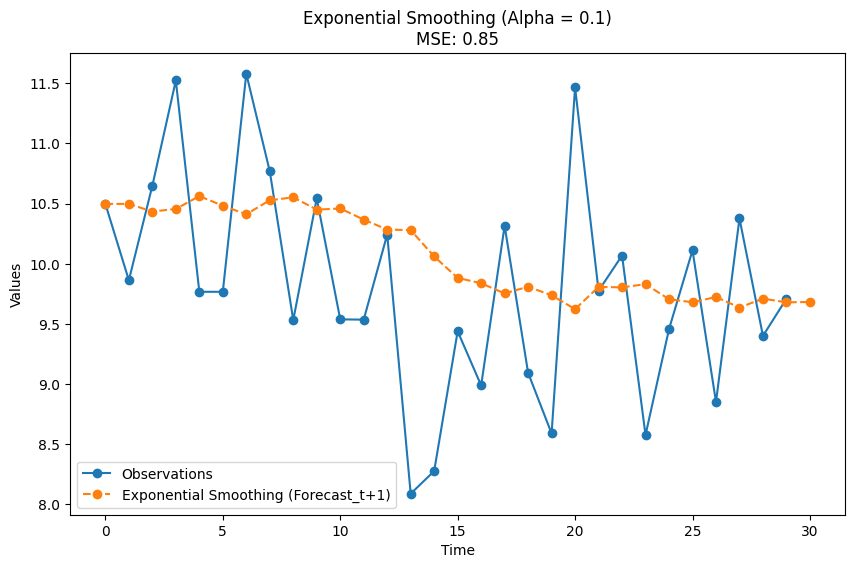

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Set seed of random number generator for reproducibility
np.random.seed(42)

# Generate exemplary stationary data
mean_value = 10
std_dev = 1
num_points = 30

data = {'Time': range(0, num_points),
        'Observations': np.random.normal(loc=mean_value, scale=std_dev, size=num_points)}

df = pd.DataFrame(data)

# Add an extra time step for forecasting using pandas.concat
df = pd.concat([df, pd.DataFrame({'Time': [num_points],
                                  'Observations': [np.nan]})], ignore_index=True)

# Set smoothing parameter
alpha = 0.1  # Adjust parameter as needed to adjust the fit

# Initialize the first forecast
df['Forecast_t+1'] = np.nan  # Use NaN for uninitialized forecasts
df.at[0, 'Forecast_t+1'] = df.at[0, 'Observations']  # First forecast equals the first observation

# Update forecast with exponential smoothing
for t in range(0, len(df) - 1):  # -1 as there was a row added, allow forecasting for the additional time step
    df.at[t + 1, 'Forecast_t+1'] = alpha * df.at[t, 'Observations'] + (1 - alpha) * df.at[t, 'Forecast_t+1']

print(df)
    
# Calculate MSE, skip first value as it's equal to the observation and last value since there is no observation left
mse = mean_squared_error(df['Observations'][1:-1] , df['Forecast_t+1'][1:-1])

# Plot observations and exponential smoothing
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Observations'], label='Observations', marker='o')
plt.plot(df['Time'], df['Forecast_t+1'], label='Exponential Smoothing (Forecast_t+1)', linestyle='dashed', marker='o')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Exponential Smoothing (Alpha = {})\nMSE: {:.2f}'.format(alpha, mse))
plt.show()



## Implementierung exponentielle Glättung 2. Ordnung nach Holt

    Time  Observations      Level     Trend  Forecast_t+1
0      0     10.496714  10.496714  0.000000           NaN
1      1     10.061736  10.366221 -0.039148     10.496714
2      2     11.047689  10.543257  0.025707     10.327073
3      3     12.123030  11.035184  0.165573     10.568965
4      4     10.565847  11.010284  0.108431     11.200758
5      5     10.765863  11.012860  0.076675     11.118716
6      6     12.779213  11.596438  0.228746     11.089534
7      7     12.167435  11.927859  0.259548     11.825183
8      8     11.130526  11.870343  0.164429     12.187407
9      9     12.342560  12.127108  0.192130     12.034772
10    10     11.536582  12.084441  0.121691     12.319238
11    11     11.734270  12.064574  0.079223     12.206132
12    12     12.641962  12.293246  0.124058     12.143797
13    13     10.686720  11.898129 -0.031694     12.417305
14    14     11.075082  11.629029 -0.102916     11.866435
15    15     12.437712  11.799593 -0.020872     11.526113
16    16     1

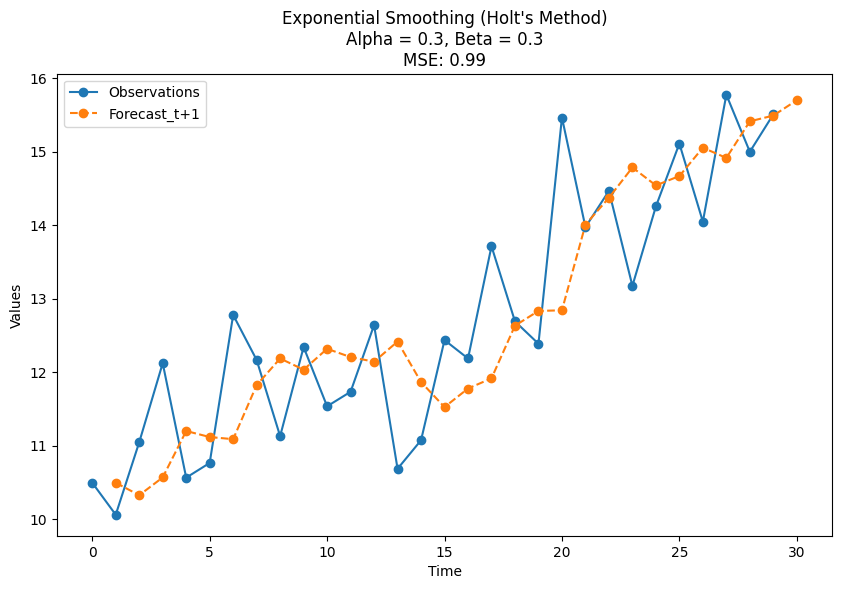

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Set seed of random number generator for reproducibility
np.random.seed(42)

# Generate exemplary data with slight trend
mean_value = 10
std_dev = 1
num_points = 30
trend = 0.2  # Added Trend

data = {
    'Time': range(0, num_points),
    'Observations': np.linspace(mean_value, mean_value + trend * (num_points - 1), num_points)
    + np.random.normal(scale=std_dev, size=num_points)
}

df = pd.DataFrame(data)

# Add an extra row for forecasting beyond the observations
df = pd.concat([df, pd.DataFrame({'Time': [num_points], 'Observations': [np.nan]})], ignore_index=True)

# Set smoothing parameters
alpha = 0.3  # Level smoothing
beta = 0.3   # Trend smoothing

# Initialize columns
df['Level'] = np.nan
df['Trend'] = np.nan
df['Forecast_t+1'] = np.nan

# Initialize the first level, trend, and forecast
df.at[0, 'Level'] = df.at[0, 'Observations']
df.at[0, 'Trend'] = 0  # Assume no initial trend
df.at[1, 'Forecast_t+1'] = df.at[0, 'Level'] + df.at[0, 'Trend']

# Update the forecast using Holt's method
for t in range(1, len(df) - 1):  # Exclude the last row as it's for forecasting
    # Update level and trend
    df.at[t, 'Level'] = alpha * df.at[t, 'Observations'] + (1 - alpha) * (df.at[t - 1, 'Level'] + df.at[t - 1, 'Trend'])
    df.at[t, 'Trend'] = beta * (df.at[t, 'Level'] - df.at[t - 1, 'Level']) + (1 - beta) * df.at[t - 1, 'Trend']
    # Forecast for the next step
    df.at[t + 1, 'Forecast_t+1'] = df.at[t, 'Level'] + df.at[t, 'Trend']

# Print the resulting DataFrame
print(df)

# Calculate MSE (exclude the first initialized forecast and the last forecast without observation)
mse = mean_squared_error(df['Observations'][1:-1], df['Forecast_t+1'][1:-1])

# Plot observations and exponential smoothing
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Observations'], label='Observations', marker='o')
plt.plot(df['Time'], df['Forecast_t+1'], label='Forecast_t+1', linestyle='dashed', marker='o')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Exponential Smoothing (Holt\'s Method)\nAlpha = {}, Beta = {}\nMSE: {:.2f}'.format(alpha, beta, mse))
plt.show()


## Implementierung exponentielle Glättung 2. Ordnung nach Winters (Holt-Winters - Methode - additives Verfahren)

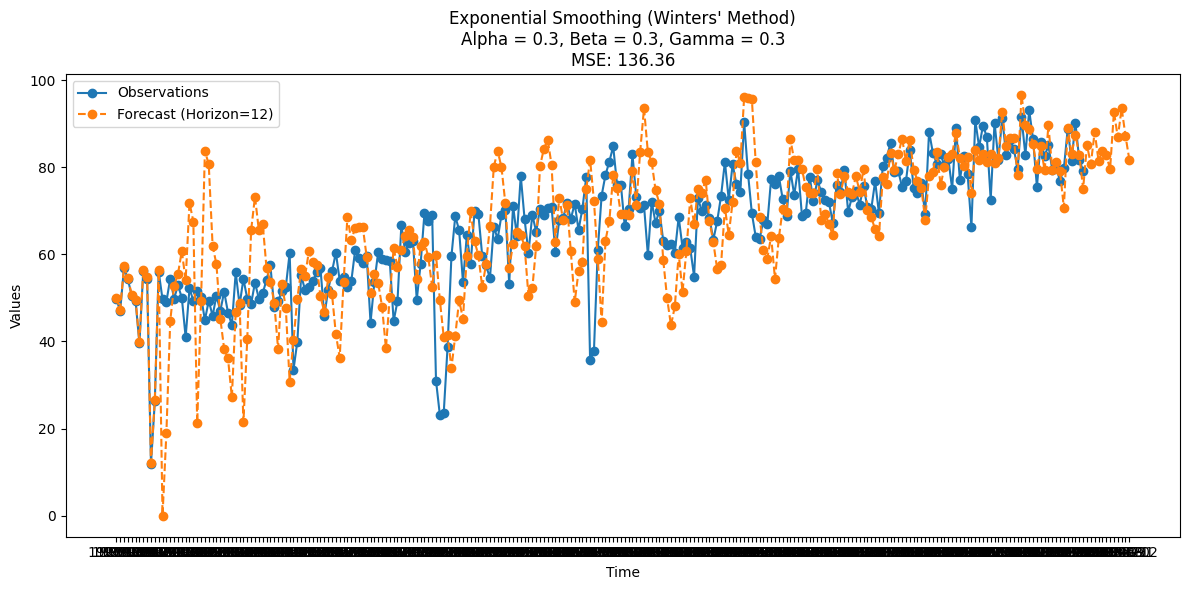

        Time  Observations   Level     Trend  Seasonal   Forecast
0    1971-01        49.780  46.016  0.299951     3.764  50.079951
1    1971-02        47.029   0.000  0.000000     1.013  47.328951
2    1971-03        56.920   0.000  0.000000    10.904  57.219951
3    1971-04        54.336   0.000  0.000000     8.320  54.635951
4    1971-05        50.442   0.000  0.000000     4.426  50.741951
..       ...           ...     ...       ...       ...        ...
259  1992-08           NaN     NaN       NaN       NaN  92.756573
260  1992-09           NaN     NaN       NaN       NaN  86.846598
261  1992-10           NaN     NaN       NaN       NaN  93.541908
262  1992-11           NaN     NaN       NaN       NaN  87.199054
263  1992-12           NaN     NaN       NaN       NaN  81.729238

[264 rows x 6 columns]


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load data from CSV
df_full = pd.read_csv('us-monthly-sales-of-petroleum-an.csv', sep=';')

# Select specific columns after inspecting the data
selected_columns = ["Month", "Coal"]  # Replace with the columns you want
df = df_full[selected_columns]

# Rename the column 'Coal' to 'Observations' -> just to be consistent w/ other examples
df = df.rename(columns={"Month": "Time", "Coal": "Observations"})

#print(len(df))

# Set smoothing parameters
alpha = 0.3  # Smoothing factor for level, example: needs to be optimized
beta = 0.3   # Smoothing factor for trend, example: needs to be optimized
gamma = 0.3  # Smoothing factor for seasonality, example: needs to be optimized
seasonal_period = 12  # Length of season (e.g., 12 for monthly data)

# Set prediction horizon
p_horizon = 12 # Forecast 12 steps ahead into future

# Initialize new columns with zeros
df['Level'] = 0.0
df['Trend'] = 0.0
df['Seasonal'] = 0.0
df['Forecast'] = 0.0

# Initialize Level, Trend, and Seasonal components
# Level (L0) is the mean of the first seasonal cycle
L0 = sum(df['Observations'][:seasonal_period]) / seasonal_period
df.at[0, 'Level'] = L0

# Trend (T0) is the difference in averages of two consecutive cycles
avg_first_cycle = sum(df['Observations'][:seasonal_period]) / seasonal_period
avg_second_cycle = sum(df['Observations'][seasonal_period:2*seasonal_period]) / seasonal_period
T0 = (avg_second_cycle - avg_first_cycle) / seasonal_period
df.at[0, 'Trend'] = T0

# Seasonal components (S0) for additive trend
for j in range(seasonal_period):
    df.at[j, 'Seasonal'] = df.at[j, 'Observations'] - L0
    
# Forecast for the first seasonal cycle
for t in range(seasonal_period):
    df.at[t, 'Forecast'] = L0 + T0 + df.at[t, 'Seasonal']

# Winters' Exponential Smoothing, "\" is an added line break for better readability
for t in range(seasonal_period, len(df)):
    # Update Level
    df.at[t, 'Level'] = alpha * (df.at[t, 'Observations'] - df.at[t - seasonal_period, 'Seasonal']) + \
                        (1 - alpha) * (df.at[t - 1, 'Level'] + df.at[t - 1, 'Trend'])
    
    # Update Trend
    df.at[t, 'Trend'] = beta * (df.at[t, 'Level'] - df.at[t - 1, 'Level']) + \
                        (1 - beta) * df.at[t - 1, 'Trend']
    
    # Update Seasonal Component
    df.at[t, 'Seasonal'] = gamma * (df.at[t, 'Observations'] - df.at[t - 1, 'Level'] - df.at[t - 1, 'Trend']) + \
                           (1 - gamma) * df.at[t - seasonal_period, 'Seasonal']
            
    # Forecast for the next p_horizon steps
    for p in range(1, p_horizon + 1):
        if t + p < len(df):  # Avoid index out-of-bounds
            df.at[t + p, 'Forecast'] = df.at[t, 'Level'] + p * df.at[t, 'Trend'] + df.at[t + p - seasonal_period, 'Seasonal']

            
# Calculate MSE (mean squared error) for observations with available forecasts
#df['Error'] = (df['Observations'] - df['Forecast'])
mse = mean_squared_error(df['Observations'], df['Forecast'])

# Extend dataframe for future forecasts by creating and appending "future_df"
future_dates = pd.date_range(start=df['Time'].iloc[-1], periods=p_horizon + 1, freq='M')[1:]
future_dates = future_dates.strftime('%Y-%m')  # Format as "YYYY-MM"

future_df = pd.DataFrame({'Time': future_dates,
                          'Observations': np.nan,
                          'Level': np.nan,
                          'Trend': np.nan,
                          'Seasonal': np.nan,
                          'Forecast': np.nan})

# Append future rows to the original DataFrame
df_extended = pd.concat([df, future_df], ignore_index=True)

# Forecast for the extended horizon out of sample forecast
for t in range(len(df), len(df_extended)):
    df_extended.at[t, 'Forecast'] = (
        df_extended.at[len(df) - 1, 'Level'] +
        (t - len(df) + 1) * df_extended.at[len(df) - 1, 'Trend'] +
        df_extended.at[t - seasonal_period, 'Seasonal']
    )

# Plot the observations and exponential smoothing results with extended forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['Observations'], label='Observations', marker='o')
plt.plot(df_extended['Time'], df_extended['Forecast'], label=f'Forecast (Horizon={p_horizon})', linestyle='dashed', marker='o')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title(f'Exponential Smoothing (Winters\' Method)\nAlpha = {alpha}, Beta = {beta}, Gamma = {gamma}\nMSE: {mse:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

print(df_extended)

# Print extended DataFrame unshortened
#print(df_extended.to_string())

## Implementierung exponentielle Glättung 2. Ordnung nach Winters (Holt-Winters - Methode - additives Verfahren)

### Optimierung mit statsmodels-Bibliothek

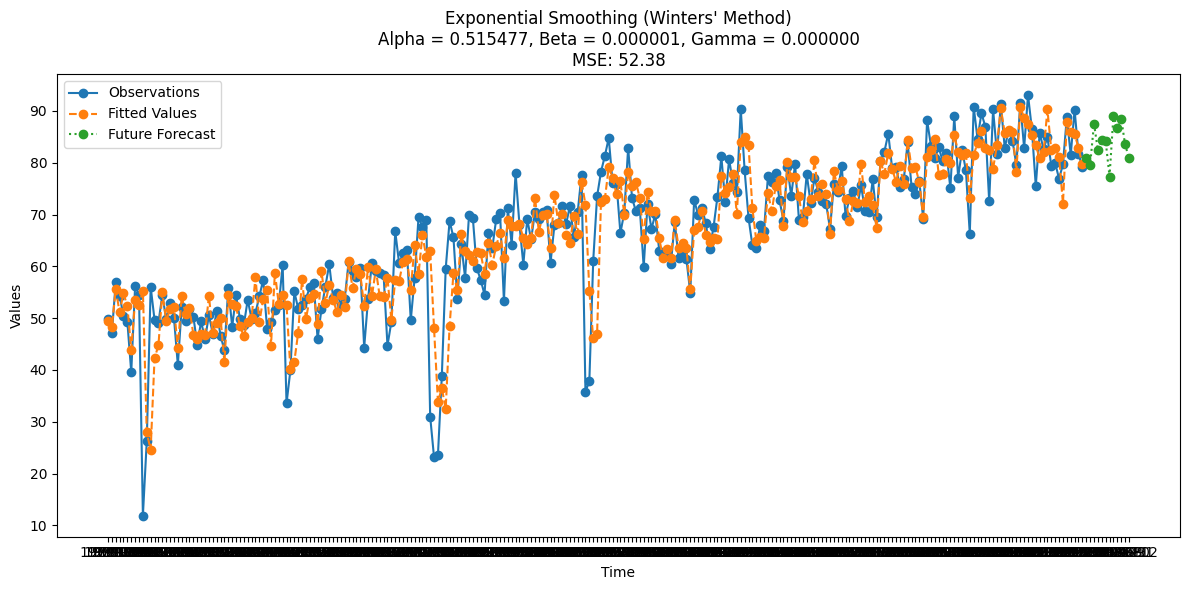

                       ExponentialSmoothing Model Results                       
Dep. Variable:             Observations   No. Observations:                  252
Model:             ExponentialSmoothing   SSE                          13200.902
Optimized:                         True   AIC                           1029.570
Trend:                         Additive   BIC                           1086.041
Seasonal:                      Additive   AICC                          1032.506
Seasonal Periods:                    12   Date:                 Tue, 14 Jan 2025
Box-Cox:                          False   Time:                         11:01:07
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5154774                alpha                 True
smoothing_trend          

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Load data from CSV
df_full = pd.read_csv('us-monthly-sales-of-petroleum-an.csv', sep=';')

# Select specific columns after inspecting the data
selected_columns = ["Month", "Coal"]  # Replace with the columns you want
df = df_full[selected_columns] # define new df

# Rename the column 'Coal' to 'Observations' and 'Month' to 'Time' -> just to be consistent w/ plots in other examples
df = df.rename(columns={"Month": "Time", "Coal": "Observations"})

# Define seasonal period of data
seasonal_period = 12 # Length of season (e.g., 12 for monthly data)

# Apply Exponential Smoothing using Holt-Winters Method: initialize define structure of model
model = ExponentialSmoothing(df['Observations'],
                              trend='additive',
                              seasonal='additive',
                              seasonal_periods=seasonal_period,
                             initialization_method = 'heuristic')

# To be consistent w/ plots in other examples, in statsmodels: smoothing_level/trend/seasonal
alpha = 0.3 # Alpha smoothing factor for level
beta = 0.3 # Beta smoothing factor for trend
gamma = 0.3 # Gamma smoothing factor for seasonality
 
# Fit the model
# Function fit() estimates parameters (alpha, beta, gamma) + updates model components (level, trend, seasonality) iteratively
# trying to minimize error between fitted values and observations
fit = model.fit()

# Generate (in-sample) predictions
df['Forecast'] = fit.fittedvalues

# Retrieve model parameters
params = fit.params
alpha = params["smoothing_level"]     # Alpha: Level smoothing
beta = params["smoothing_trend"]      # Beta: Trend smoothing
gamma = params["smoothing_seasonal"]  # Gamma: Seasonal smoothing

# Forecast future values: using fitted model to compute forecast values
p_horizon = 12 # forecast/steps ahead into future
future_forecast = fit.forecast(p_horizon)

# Extend the dataframe for future forecasts
future_time = pd.date_range(start=df['Time'].iloc[-1], periods=p_horizon + 1, freq='M')[1:]
future_time = future_time.strftime('%Y-%m')  # Format as "YYYY-MM"

future_df = pd.DataFrame({'Time': future_time, 'Observations': np.nan, 'Forecast': future_forecast})


# Concatenate the original and future data if you want/need for further analysis
#full_df = pd.concat([df, future_df], ignore_index=True)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(df['Observations'], df['Forecast'])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['Observations'], label='Observations', marker='o')
plt.plot(df['Time'], df['Forecast'], label='Fitted Values', linestyle='dashed', marker='o')
plt.plot(future_df['Time'], future_df['Forecast'], label='Future Forecast', marker='o', linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title(f'Exponential Smoothing (Winters\' Method)\nAlpha = {alpha:.6f}, Beta = {beta:.6f}, Gamma = {gamma:.6f}\nMSE: {mse:.2f}')
plt.tight_layout()
plt.show()

print(fit.summary())

# print complete, unshortened df w/ all rows
#print(df.to_string())

# Print future forecast
print("Future Forecast:")
print(future_df)

<div class="alert alert-block alert-info">
Die ersten Prognosewerte können zunächst u. U. stark von den tatsächlichen Bedarfswerten abweichen. Die Anpassung des Saisonfaktors erfolgt allerdings recht schnell.
    </div>

## Implementierung ARMA-Klasse Modell

Die Erstellung und Implementierung eines ARMA-Klasse Modells kann in 3 Schritte eingeteilt werden
1. Zeitreihe auf Stationariät prüfen
2. Bestimmung des Models und Identifikation der Ordnung/Anzahl der lags
3. Modell erstellen, implementieren und Koeffizienten berechnen (lassen von Software)

### 0. Import und Visualisierung/Plot der Zeitreihe

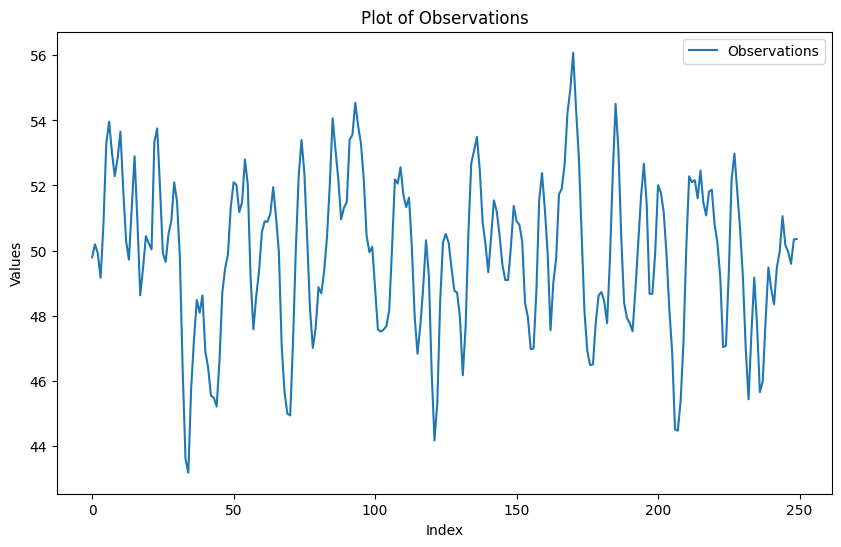

       Observations
Index              
0         49.795292
1         50.192353
2         49.913212
3         49.164210
4         50.815773

Total number of Observations:  250


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load from CSV
df = pd.read_csv('output_Observations.csv', index_col=0)

# Plot
plt.figure(figsize=(10, 6))

# Assuming your data column is named 'Observations', change according to dataset if needed
plt.plot(df['Observations'], label='Observations') # ['Observations'] actual column name in dataset, label = data label in plot

# Customize the plot
plt.title('Plot of Observations')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()

# Show first rows of data, this function can be generally helpful to get an idea about the dataset
print(df.head())

# Show lenght of data column
print('\nTotal number of Observations: ', len(df))

### 1. Zeitreihe auf Stationarität prüfen: Augmented Dickey-Fuller test (ADF)

ADF Statistic: -5.305124426267265
p-value: 5.343395236968036e-06
Critical Values: {'1%': -3.457437824930831, '5%': -2.873459364726563, '10%': -2.573122099570008}

Reject the null hypothesis. The time series data is likely stationary.
Differencing: 0 



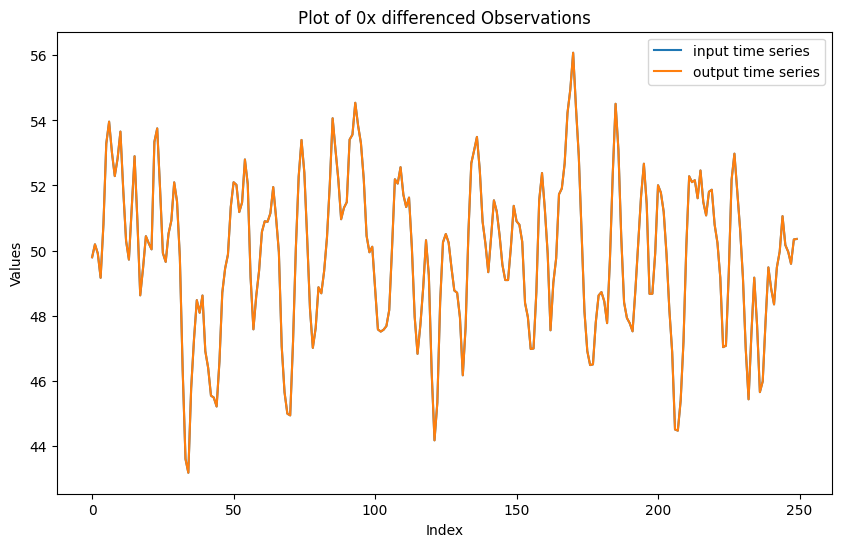

       Observations
Index              
0         49.795292
1         50.192353
2         49.913212
3         49.164210
4         50.815773 

Total number of Observations (original):  250 



In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# ACF and PACF assume stationarity of time series

# Create reusable function snippet and perform Augmented Dickey-Fuller test
# Function tests for stationarity: differencing when test fails, repeats differencing if needed
# Differencing iterations i represent order for Integrated part in ARIMA model
# Returns differenced input time series for further analyses

def testStationarityADFuller(timeseries_input):
    iterations = 0
    result = [1,1,1,1,1,1] #initialize
    
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries_input, label='input time series')
    
    
    while result[1] > 0.05:
        result = adfuller(timeseries_input)

        # Extract and print the results
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        print('Critical Values:', result[4])

        # Interpret the results
        if result[1] <= 0.05:
            print("\nReject the null hypothesis. The time series data is likely stationary.")
            print(f'Differencing:', iterations, '\n')
                
        else:
            print("\nFail to reject the null hypothesis. The time series data may not be stationary. Differencing the series.")
            timeseries_input = timeseries_input.diff().dropna() # differencing, drop missing values
            print(f'Differencing:', iterations, '\n')
            iterations += 1
                                
    
    plt.plot(timeseries_input, label='output time series')
    # Customize the plot
    plt.title('Plot of %ix differenced Observations' %iterations)
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.legend()
    
    # Show the plot
    plt.show()

    return timeseries_input #first value returned series not considered, after 1x differencing it is NaN -> output[1:]

# Create a DataFrame to store the results
df_adf = pd.DataFrame()

# Call ADF function with time series data
# return data for further analyses (differenced if not stationary)
df_adf['Observations']=testStationarityADFuller(df['Observations'])

# Show first rows of original and differenced data
# Differencing reduces total size of data by 1: len(diff_data) = len(original_data)-1
print(df.head(),'\n')
print('Total number of Observations (original): ', len(df), '\n')

if len(df_adf)!=len(df):
    print(df_adf.head(), '\n')
    print('Total number of Observations (differenced): ', len(df_adf), '\n')

### ADF Test Ergebnisse interpretieren:

Der Augmented Dickey-Fuller-Test (ADF) prüft die Nullhypothese, dass eine Einheitswurzel in einer Zeitreihenstichprobe vorhanden ist. In der Zeitreihenanalyse wird von einer Einheitswurzel gesprochen, wenn 1 eine Nullstelle des charakteristischen Polynoms ist. Stochastische Prozesse, die eine solche Einheitswurzel besitzen, sind nicht stationär. Sie haben einen stochastischen Trend.


Bei der Interpretation der Ergebnisse eines ADF-Tests wird der verbundene *p-Wert* betrachtet. Ist der *p-Wert* kleiner als ein gewähltes Signifikanzniveau (häufig 0,05), kann die Nullhypothese zur Existenz einer Einheitswurzel zurückgewiesen werden. Die geprüfte Zeitreihe ist sehr wahrscheinlich stationär. Umgekehrt kann die Nullhypothese nicht zurückgewiesen werden, sobald der p-Wert größer als das Signifikanzniveau ist. In diesem Fall ist die geprüfte Zeitreihe sehr wahrscheinlich nicht stationär (Manu 2022, S. 143-144).

Ausgesprochen:

**p = 0.96**: "Zu 96% hat die getestete Zeitreihe eine Einheitswurzel." oder "Zu 96% ist die Zeitreihe nicht stationär."

**p = 0.04**: "Zu 4% hat die getestete Zeitreihe eine Einheitswurzel." oder "Zu 4% ist die Zeitreihe nicht stationär."


Neben dem p-Wert wird die Teststatistik selbst betrachtet. Ist der Wert der Teststatistik negativer als die in der ADF-Tabelle angegebenen kritischen Werte auf den Signifikanzniveaus 1%, 5% und 10%, kann auch hier die Nullhypothese der Existenz einer Einheitswurzel zurückgewiesen werden und die Zeitreihe als sehr wahrscheinlich stationär eingestuft werden.

### 2. Bestimmung des Models und Identifikation der Ordnung/Anzahl der lags

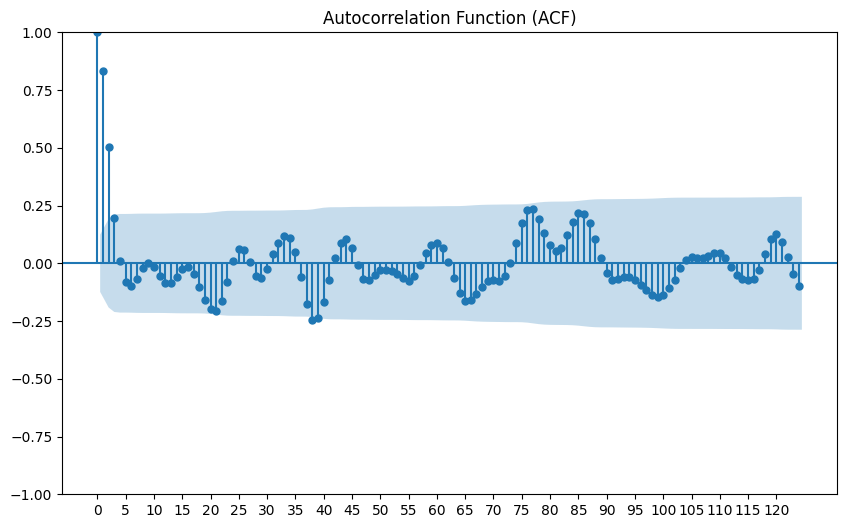

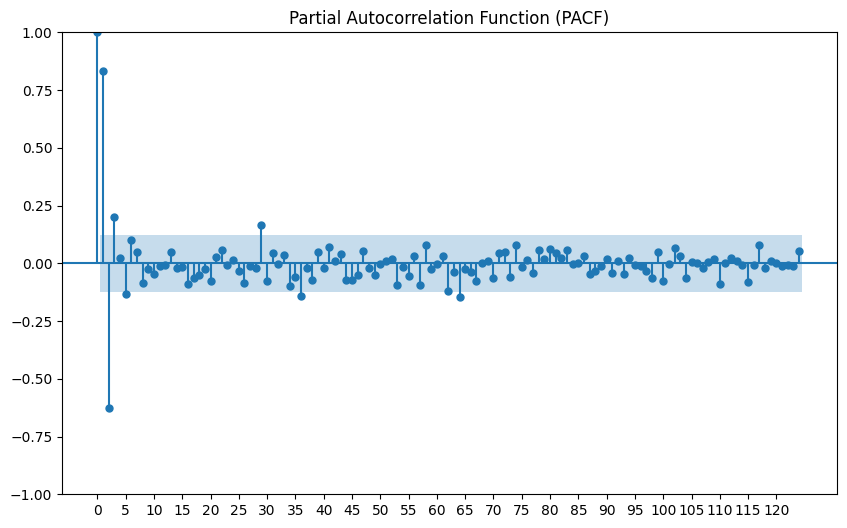

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Compute and plot Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
lags = (int((len(df_adf['Observations'])/2-1)))  # specify number of lags to consider (max. = 50% of all observations)

# ACF using plot_acf function from statsmodels
fig, ax1 = plt.subplots(figsize=(10, 6)) # plot_acf() uses subplots internally
plot_acf(df_adf['Observations'], lags=lags, title='Autocorrelation Function (ACF)', ax=ax1)
plt.xticks(np.arange(0, lags + 1, 5))
plt.show()

# PACF using plot_pacf function from statsmodels
fig, ax2 = plt.subplots(figsize=(10, 6)) # plot_pacf() uses subplots internally
plot_pacf(df_adf['Observations'], lags=lags, method='ywm', title='Partial Autocorrelation Function (PACF)',ax=ax2)
plt.xticks(np.arange(0, lags + 1, 5))
plt.show()


<div class="alert alert-block alert-info">
    Bei der Betrachtung ACF and PACF Plots werden Spitzen bei $t_0$ ignoriert, da sie die Korrelation des Wertes mit sich selbst zeigen. <br>
Es ist zu beachten, dass in einigen Bibliotheken/Softwareanwendungen die Werte bei $t_0$ direkt entfernt und nicht im Plot angezeigt werden. Hier ist Achtsamkeit geboten, da sonst die Ordnungen fehlerhaft abgelesen werden können.
</div>

Auf Grundlage der obigen ACF und PACF Plots erscheint ein ARMA(2,2) Modell ein guter Anfang zu sein, um die Daten zu erklären.

### 3. Modell erstellen, implementieren und Koeffizienten berechnen: statsmodels

                               SARIMAX Results                                
Dep. Variable:           Observations   No. Observations:                  250
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -353.367
Date:                Tue, 14 Jan 2025   AIC                            718.735
Time:                        11:01:40   BIC                            739.863
Sample:                             0   HQIC                           727.238
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.8735      0.306    162.982      0.000      49.274      50.473
ar.L1          0.7975      0.143      5.587      0.000       0.518       1.077
ar.L2         -0.2303      0.125     -1.847      0.0

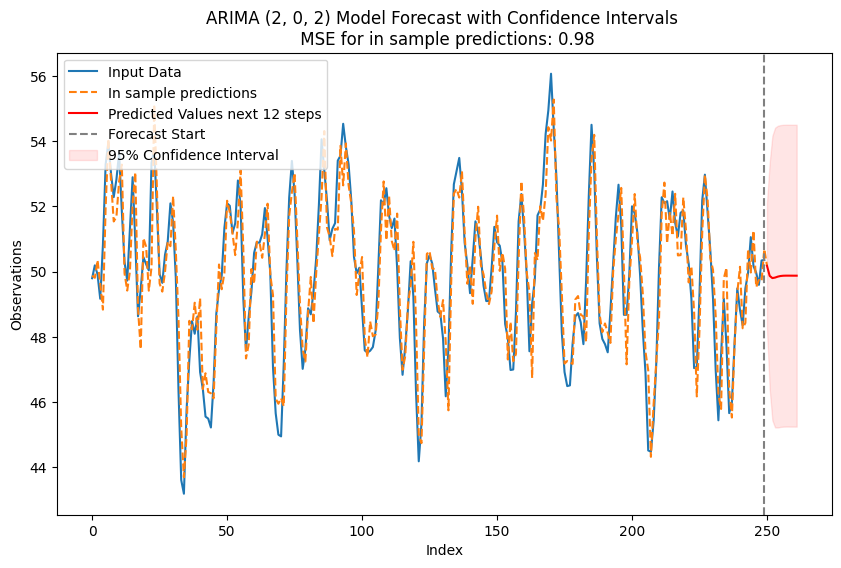

In [10]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# Load dataset from CSV file
df = pd.read_csv('output_Observations.csv', index_col=0)

# Assuming your dataset has a column named 'Observations' (change accordingly)
data = df['Observations']

# Fit model, here: ARMA(2,2) based on ACF/PACF plots above
# statsmodels has no class ARMA, instead use ARIMA with order d=0
order = (2, 0, 2) # adjust orders for AR, I, MA based on ACF and PACF plots and/or as needed
model = sm.tsa.ARIMA(data, order=order)
results = model.fit()

# Display model summary
print(results.summary(), '\n')

# predict() method is used to obtain in-sample predictions
# It predicts values for same time period as training data.

# get_forecast() method is used for out-of-sample forecasting.
# It forecasts values beyond last observed time point in training data.

# Forecast next steps into the future using get_forecast()
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)

# Extract forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

in_sample_predictions = results.predict(start=0, end=len(data), dynamic=False)

# Display forecast values
print("Forecast values for the next {} steps:".format(forecast_steps))
print(forecast_values, '\n')

# Calculate Mean Squared Error (MSE)
mse_t = mean_squared_error(df['Observations'], in_sample_predictions.iloc[0:len(data)])

# Plotting
plt.figure(figsize=(10, 6))

# Plot input data
plt.plot(df.index, data, label='Input Data')

# plot in sample predictions
plt.plot(range(0, len(data)+1), in_sample_predictions, label='In sample predictions', linestyle='dashed')

# Plot predicted values at the end of the input data using numerical indices
plt.plot(range(len(data), len(data) + forecast_steps), forecast_values, label='Predicted Values next {} steps'.format(forecast_steps), color='red')

plt.axvline(data.index[-1], color='gray', linestyle='--', label='Forecast Start')

# Plot confidence intervals
lower_bound = len(data)
upper_bound = len(data) + forecast_steps
plt.fill_between(range(lower_bound, upper_bound), forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.1, label='95% Confidence Interval')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Observations')
plt.title('ARIMA {} Model Forecast with Confidence Intervals \n MSE for in sample predictions: {:.2f}'.format(order, mse_t))
plt.legend(loc='upper left')

# Show the plot
plt.show()

## Implementierung ARMA-Klasse Modell mit "auto_arima"

Die Erstellung und Implementierung eines ARMA-Klasse Modells kann in 3 Schritte eingeteilt werden
1. Zeitreihe auf Stationariät prüfen
2. Bestimmung des Models und Identifikation der Ordnung/Anzahl der lags
3. Modell erstellen, implementieren und Koeffizienten berechnen (lassen von Software)

Die Bibliothek ***pmdarima*** mit der Funktion ***auto_arima*** kann diese Schritte automatisiert ausführen und die Modellparameter optimieren.

Der Datensatz sollte vorher unter Anwendung der ACF und PACF auf Saisonalität überprüft werden. Hier kann dann auch eine eventuelle Periodizität abgelesen werden. Bei einer vorhandenen Saisonalität im Datensatz sind SARIMA Modelle (saisonale ARIMA Modelle) besser geeignet als AR, MA, ARMA oder ARIMA Modelle. Solche SARIMA Modelle deckt ***pmdarima*** ebenso ab.

Bei dem obigen Beispiel lassen ACF und PACF auf keine Saisonalität in den Daten schließen.

Bevor ***auto_arima*** genutzt werden kann, muss die Bibliothek ***pmdarima*** installiert werden.

In [ ]:
# run this cell to install pmdarima library
%pip install pmdarima

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2666.842, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=798.628, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=793.145, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=779.911, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2029.404, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=775.184, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=781.567, Time=0.23 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(2,0,4

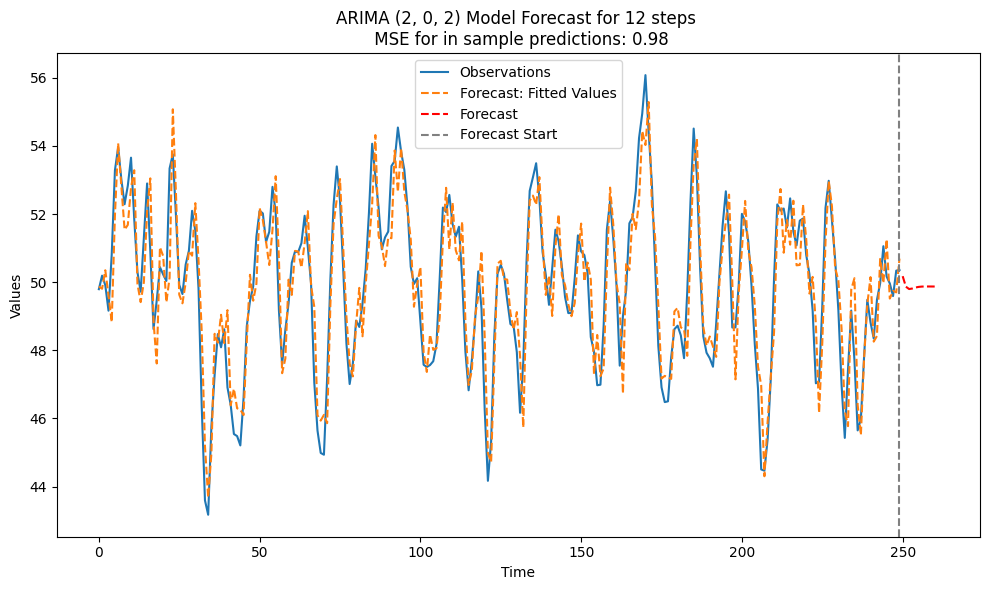

In [12]:
'''
pmdarima
auto_arima demo
'''

import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load dataset
df = pd.read_csv('output_Observations.csv', index_col=0)
data = df['Observations']

# Fit Auto ARIMA model and optimize parameters (no saisonality in data)
model = auto_arima(data, seasonal=False, trace=True)

# Model orders optimized by auto_arima()
model_order = model.order

# Print model summary
print(model.summary())

# Generate in-sample predictions (fitted values)
fitted_values = model.predict_in_sample()

# Forecast future values (out-of-sample predictions)
p_horizon = 12  # Forecast 12 steps ahead
forecast = model.predict(n_periods=p_horizon)


# Calculate MSE for in-sample predictions (fitted values)
mse = mean_squared_error(df['Observations'], fitted_values)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df['Observations'], label='Observations')
plt.plot(fitted_values, label='Forecast: Fitted Values', linestyle='dashed')
plt.plot(forecast, label='Forecast', linestyle='dashed', color='red')
plt.axvline(data.index[-1], color='gray', linestyle='--', label='Forecast Start')

plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('ARIMA {} Model Forecast for {} steps \n MSE for in sample predictions: {:.2f}'.format(model_order,p_horizon, mse))
plt.tight_layout()
plt.show()

Es ist zu erkennen, dass das Modell mit den bestimmten Ordnungen und berechneten Parametern die Zeitreihe prinzipiell gut erklären kann (s. Plot und MSE), aber nur für kurze Prognosezeiträume sinnvoll einsetzbar ist. In diesem Beispiel liegt es vor allem daran, dass der Datensatz mit ***Fokus auf Verständlichkeit bei der ACF und PACF synthetisch erzeugt wurde*** und daher recht viel Rauschen um den Mittelwert aufweist. Aus diesem Grund flachen die Prognosewerte recht schnell zum Mittelwert ab.

Die von der Bibliothek *statsmodels* berechneten Modellkoeffizienten und Konstante, neben weiteren Metriken, sind in der Tabelle **SARIMAX Results** über dem Modell-Plot aufgeführt:

|Results|Beschreibung|
|:-|:-|
|const|Konstante|
|ar.L1 |Koeffizient 1. Autoregressiver-Term (AR) |
|ar.L2 |Koeffizient 2. Autoregressiver-Term (AR) |
|ma.L1 |Koeffizient 1. Moving Average Term (MA) |
|ma.L2 |Koeffizient 2. Moving Average Term (MA) |

<br>
<br>
<br>

Hinweis: Der Name *SARIMAX Results* ist ein Platzhaltername für das Zusammenfassungsfenster. Er ist für alle mit den genutzten Klassen und Funktionen der Bibliothek erstellbaren Modelle gleich und entspricht nicht unbedingt dem tatsächlichen Modell (hier: ARIMA(2,0,2)).

# Literaturverzeichnis

Joseph, Manu (2022): Modern Time Series Forecasting with Python. Explore industry-ready time series forecasting using modern machine learning and deep learning. Birmingham: Packt Publishing Limited.